In [1]:
#!pip install datosgobmx

In [2]:
import os
from requests import get
from io import BytesIO
from zipfile import ZipFile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
tqdm.pandas()
from ipywidgets import interact,widgets, HBox, Output
from ipywidgets.embed import embed_minimal_html
import folium
import plotly.express as px

C:\Users\mb45296\AppData\Local\Continuum\anaconda4\lib\site-packages\tqdm\std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [3]:
request = get('http://187.191.75.115/gobmx/salud/datos_abiertos/datos_abiertos_covid19.zip')
zip_file = ZipFile(BytesIO(request.content))
zip_file.extractall(os.getcwd())
files = zip_file.namelist()
covidgob=pd.read_csv(files[0],parse_dates=["FECHA_INGRESO"],index_col="FECHA_INGRESO",encoding='latin-1')
covidgob.head()

FECHA_ACTUALIZACION ID_REGISTRO  ORIGEN  SECTOR  ENTIDAD_UM  \
FECHA_INGRESO                                                               
2020-06-01             2020-06-18      1ccc07       2       3          15   
2020-06-06             2020-06-18      17a525       2       3          27   
2020-06-13             2020-06-18      0c43e9       2       3          27   
2020-03-31             2020-06-18      148214       2       4           2   
2020-04-04             2020-06-18      001423       2       4           9   

               SEXO  ENTIDAD_NAC  ENTIDAD_RES  MUNICIPIO_RES  TIPO_PACIENTE  \
FECHA_INGRESO                                                                 
2020-06-01        1           15           15             20              1   
2020-06-06        2           27           27              4              2   
2020-06-13        2           27           27              2              1   
2020-03-31        2            2            2              4              2   
2020-04-04        2            9            9              2              2   

               ... CARDIOVASCULAR OBESIDAD  RENAL_CRONICA  TABAQUISMO  \
FECHA_INGRESO  ...                                                      
2020-06-01     ...              2        2              2           2   
2020-06-06     ...              2        2              1           2   
2020-06-13     ...              2        2              2           2   
2020-03-31     ...              1        2              2           2   
2020-04-04     ...              2        2              2           2   

               OTRO_CASO  RESULTADO  MIGRANTE  PAIS_NACIONALIDAD  PAIS_ORIGEN  \
FECHA_INGRESO                                                                   
2020-06-01             1          1        99            MÃ©xico           99   
2020-06-06            99          1        99            MÃ©xico           99   
2020-06-13             2          1        99            MÃ©xico           99   
2020-03-31            99          1        99            MÃ©xico           99   
2020-04-04            99          1        99            MÃ©xico           99   

               UCI  
FECHA_INGRESO       
2020-06-01      97  
2020-06-06       2  
2020-06-13      97  
2020-03-31       2  
2020-04-04       2  

[5 rows x 34 columns]

In [4]:
catmun=pd.read_csv("AGEEML_20204171136615.csv",encoding= 'unicode_escape')
catfmun=catmun.groupby(["Cve_Ent","Cve_Mun"],as_index=False)[["Lat_Decimal","Lon_Decimal"]].mean()
#catfmun.sort_values(["Cve_Ent","Cve_Loc"])
len(catfmun)

C:\Users\mb45296\AppData\Local\Continuum\anaconda4\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2465

In [5]:
ind=covidgob.index
covidgob=pd.merge(covidgob,catfmun[["Cve_Ent","Cve_Mun","Lat_Decimal","Lon_Decimal"]],left_on=["ENTIDAD_RES","MUNICIPIO_RES"],right_on=["Cve_Ent","Cve_Mun"],how="left")

In [6]:
covidgob.index=ind

In [7]:
ents=pd.read_excel("Catalogos_0412.xlsx",sheet_name="Catálogo de ENTIDADES")
muns=pd.read_excel("Catalogos_0412.xlsx",sheet_name="Catálogo MUNICIPIOS")
orig=pd.read_excel("Catalogos_0412.xlsx",sheet_name="Catálogo ORIGEN")
sector=pd.read_excel("Catalogos_0412.xlsx",sheet_name="Catálogo SECTOR")
sexo=pd.read_excel("Catalogos_0412.xlsx",sheet_name="Catálogo SEXO")

tp=pd.read_excel("Catalogos_0412.xlsx",sheet_name="Catálogo TIPO_PACIENTE")
bina=pd.read_excel("Catalogos_0412.xlsx",sheet_name="Catálogo SI_NO")
nac=pd.read_excel("Catalogos_0412.xlsx",sheet_name="Catálogo NACIONALIDAD")

res=pd.read_excel("Catalogos_0412.xlsx",sheet_name="Catálogo RESULTADO",skiprows=1)


In [8]:
binx=dict()
for i in range(len(bina)):
    binx[bina.iloc[i,0]]=bina.iloc[i,1]
binx    

{1: 'SI ', 2: 'NO ', 97: 'NO APLICA', 98: 'SE IGNORA', 99: 'NO ESPECIFICADO'}

In [9]:
sal=(pd.merge(covidgob,ents[["CLAVE_ENTIDAD","ENTIDAD_FEDERATIVA"]],left_on="ENTIDAD_RES",right_on="CLAVE_ENTIDAD",how="left").drop("CLAVE_ENTIDAD",axis=1)).rename(columns={"ENTIDAD_FEDERATIVA":"entidad_res"})
sal=(pd.merge(sal,muns,left_on=["ENTIDAD_RES","MUNICIPIO_RES"],right_on=["CLAVE_ENTIDAD","CLAVE_MUNICIPIO"],how="left").drop(["CLAVE_ENTIDAD","CLAVE_MUNICIPIO"],axis=1)).rename(columns={"MUNICIPIO":"municipio_res"})
sal=(pd.merge(sal,sector,left_on=["SECTOR"],right_on=["CLAVE"],how="left").drop(["CLAVE"],axis=1)).rename(columns={"DESCRIPCIÓN":"sector"})
sal=(pd.merge(sal,sexo,left_on=["SEXO"],right_on=["CLAVE"],how="left").drop(["CLAVE"],axis=1)).rename(columns={"DESCRIPCIÓN":"sexo"})
sal=(pd.merge(sal,tp,left_on=["TIPO_PACIENTE"],right_on=["CLAVE"],how="left").drop(["CLAVE"],axis=1)).rename(columns={"DESCRIPCIÓN":"tipo_paciente"})
sal=(pd.merge(sal,res,left_on=["RESULTADO"],right_on=["CLAVE"],how="left").drop(["CLAVE"],axis=1)).rename(columns={"DESCRIPCIÓN":"resultado"})
sal.drop(["ENTIDAD_RES","MUNICIPIO_RES","SECTOR","SEXO","TIPO_PACIENTE"],axis=1,inplace=True)

In [10]:
sal.index=covidgob.index
sal["ran_edad"]=pd.qcut(sal['EDAD'], q=20)

bincols=["INTUBADO","NEUMONIA",'EMBARAZO', 'HABLA_LENGUA_INDIG', 'DIABETES', 'EPOC',
       'ASMA', 'INMUSUPR', 'HIPERTENSION', 'OTRA_COM', 'CARDIOVASCULAR',
       'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO', 'OTRO_CASO']

for col in bincols:
    sal[col.lower()]=sal[col].apply(lambda x: binx[x])
#sal.head()
sal.drop(bincols,axis=1,inplace=True)

In [11]:
sal['defunción']=(sal.apply(lambda x: 1 if (x['FECHA_DEF']!="9999-99-99" and x['RESULTADO']==1) else 0,axis=1))
#sal[(sal["FECHA_DEF"]!="9999-99-99") & (sal["RESULTADO"]==1)]

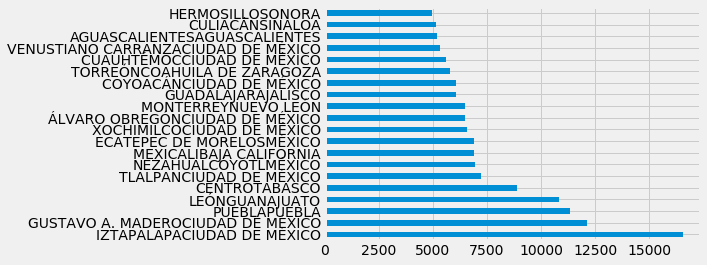

In [12]:
plt.style.use("fivethirtyeight")
((sal["municipio_res"]+sal["entidad_res"].astype(str)).value_counts()).sort_values(ascending=False)[:20].plot.barh()

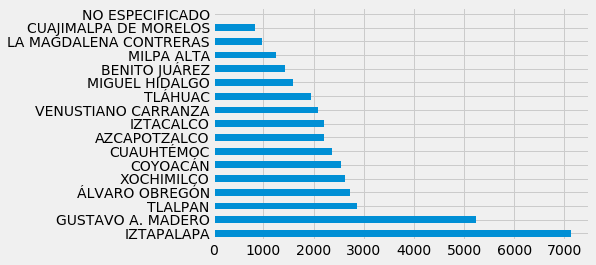

In [13]:
(sal[(sal["entidad_res"]=="CIUDAD DE MÉXICO") & (sal["resultado"]=="Positivo SARS-CoV-2")]["municipio_res"].value_counts()).sort_values(ascending=False)[:20].plot.barh()

In [14]:
sal["resultado"].value_counts()

No positivo SARS-CoV-2    228248
Positivo SARS-CoV-2       165455
Resultado pendiente        59778
Name: resultado, dtype: int64

In [15]:
sal['defunción'].sum()

19747

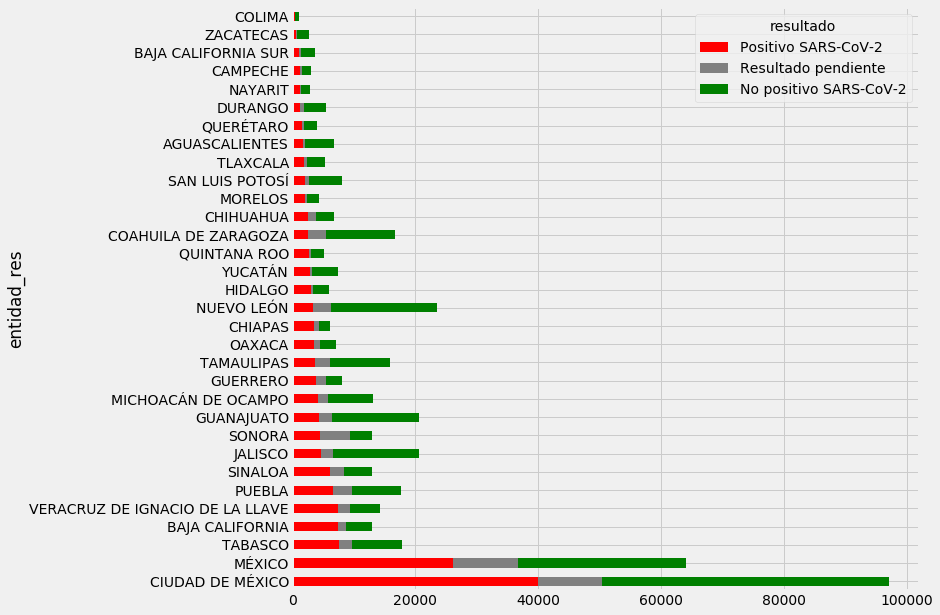

In [16]:
ents=pd.DataFrame(sal.groupby(["entidad_res","resultado"],as_index=False).agg({"ID_REGISTRO":'count','defunción':'sum'}))
edos=(ents.pivot_table(index="entidad_res",columns="resultado",values=["ID_REGISTRO","defunción"])).sort_values(('ID_REGISTRO',    'Positivo SARS-CoV-2'),ascending=False)
((edos["ID_REGISTRO"][["Positivo SARS-CoV-2","Resultado pendiente","No positivo SARS-CoV-2"]]).sort_values("Positivo SARS-CoV-2",ascending=False)).plot.barh(stacked=True,color=['r','gray','g'],figsize=(10,10))
plt.show()

In [17]:
ents.sort_values("ID_REGISTRO",ascending=False)

entidad_res               resultado  ID_REGISTRO  defunción
18     CIUDAD DE MÉXICO  No positivo SARS-CoV-2        46692          0
19     CIUDAD DE MÉXICO     Positivo SARS-CoV-2        40021       4249
48               MÉXICO  No positivo SARS-CoV-2        27316          0
49               MÉXICO     Positivo SARS-CoV-2        26079       3315
54           NUEVO LEÓN  No positivo SARS-CoV-2        17396          0
..                  ...                     ...          ...        ...
8   BAJA CALIFORNIA SUR     Resultado pendiente          212          0
65            QUERÉTARO     Resultado pendiente          208          0
95            ZACATECAS     Resultado pendiente          204          0
53              NAYARIT     Resultado pendiente          180          0
26               COLIMA     Resultado pendiente          115          0

[96 rows x 4 columns]

In [18]:
#(ents.pivot_table(index="entidad_res",columns="resultado",values=["ID_REGISTRO","defunción"])).sort_values(('ID_REGISTRO',    'Positivo SARS-CoV-2'),ascending=False)

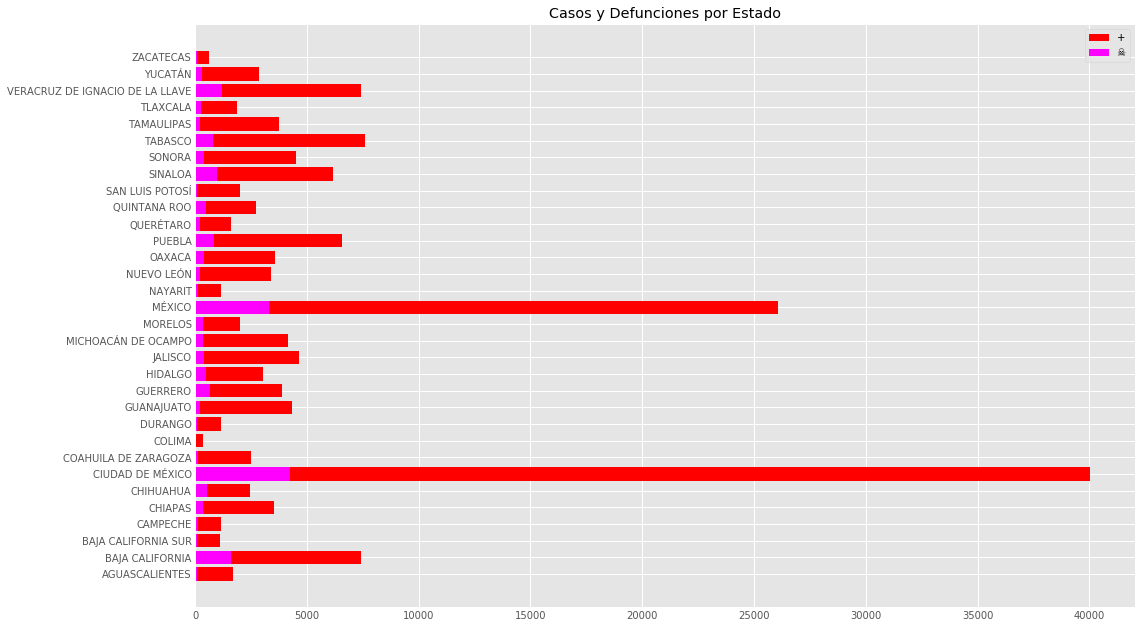

<Figure size 432x288 with 0 Axes>

In [19]:
plt.style.use("ggplot")
plt.figure(figsize=(15,10))
plt.barh(ents[(ents["resultado"]=="Positivo SARS-CoV-2")]["entidad_res"].values,ents[(ents["resultado"]=="Positivo SARS-CoV-2")]["ID_REGISTRO"].values,label="+",color="r")
plt.barh(ents[(ents["resultado"]=="Positivo SARS-CoV-2")]["entidad_res"].values,ents[(ents["resultado"]=="Positivo SARS-CoV-2")]["defunción"].values,label="\u2620",color="magenta")
plt.legend()
plt.grid("black")
plt.title("Casos y Defunciones por Estado")
plt.show()
plt.savefig("casos.pdf")

In [20]:
categs=sal.select_dtypes(["int64","category","object"]).columns

In [21]:
def cruces(cat,ent,mun):
    if mun in list(sal[sal["entidad_res"]==ent]["municipio_res"].unique()):
        
        plt.figure(figsize=(15,10))
        plt.barh(sal[(sal["RESULTADO"]==2) & (sal["entidad_res"]==ent) & (sal["municipio_res"]==mun)][cat].value_counts().index.astype(str),sal[(sal["RESULTADO"]==2) & (sal["entidad_res"]==ent) & (sal["municipio_res"]==mun)][cat].value_counts(),label="--",color="g")
        plt.barh(sal[(sal["RESULTADO"]==3) & (sal["entidad_res"]==ent) & (sal["municipio_res"]==mun)][cat].value_counts().index.astype(str),sal[(sal["RESULTADO"]==3) & (sal["entidad_res"]==ent) & (sal["municipio_res"]==mun)][cat].value_counts(),label="pend",color="gray")
        plt.barh(sal[(sal["RESULTADO"]==1) & (sal["entidad_res"]==ent) & (sal["municipio_res"]==mun)][cat].value_counts().index.astype(str),sal[(sal["RESULTADO"]==1) & (sal["entidad_res"]==ent) & (sal["municipio_res"]==mun)][cat].value_counts(),label="+",color="r")
        plt.legend()
        plt.show()
interact(cruces,cat=categs,ent=sal["entidad_res"].unique(),mun=sal["municipio_res"].unique())    

interactive(children=(Dropdown(description='cat', options=('FECHA_ACTUALIZACION', 'ID_REGISTRO', 'ORIGEN', 'EN…

<function __main__.cruces(cat, ent, mun)>

In [22]:
ej=pd.DataFrame(sal.groupby(["entidad_res","municipio_res","resultado"],as_index=False).agg({'RESULTADO':'count',"Lat_Decimal":'mean',"Lon_Decimal":'mean','defunción':'sum'}))
#ej['RESULTADO'].sum()
#ej.head()
ej["municipio_res"]=ej["entidad_res"]+","+ej["municipio_res"]
ej.drop("entidad_res",axis=1,inplace=True)
ctg=ej.groupby(["municipio_res"])[["Lat_Decimal","Lon_Decimal"]].mean()
ctdef=ej.groupby(["municipio_res"])["defunción"].sum()
paraf=pd.pivot(ej.drop(["Lat_Decimal","Lon_Decimal"],axis=1),columns="resultado",index="municipio_res",values="RESULTADO").fillna(0)
paraf=paraf.join(ctg,how="left")
paraf=(paraf.join(ctdef,how="left").reset_index()).fillna(0)
paraf[paraf["Lat_Decimal"].isnull()]

Empty DataFrame
Columns: [municipio_res, No positivo SARS-CoV-2, Positivo SARS-CoV-2, Resultado pendiente, Lat_Decimal, Lon_Decimal, defunción]
Index: []

In [23]:
def colors(x):
    color1=''
    color2=''
    if x>=np.percentile(paraf["Positivo SARS-CoV-2"].values,99):
        color1='red'
        color2='black'
    elif x>=np.percentile(paraf["Positivo SARS-CoV-2"].values,95):
        color1='orange'
        color2='blue'
    elif x>=np.percentile(paraf["Positivo SARS-CoV-2"].values,90):
        color1='gray'
        color2='green'
    else:
        color1='green'
        color2='yellow'
    return color1,color2    

In [24]:
ejx=sal[sal["RESULTADO"]==1].groupby([sal[sal["RESULTADO"]==1].index,"entidad_res",'municipio_res'])[["RESULTADO"]].sum()
ejx=ejx.reset_index()
ejx["municipio_resx"]=ejx["entidad_res"]+","+ejx["municipio_res"]
ejx.drop(["entidad_res",'municipio_res'],axis=1,inplace=True)
ejx.index=ejx["FECHA_INGRESO"]
ejx

FECHA_INGRESO  RESULTADO                       municipio_resx
FECHA_INGRESO                                                              
2020-01-13       2020-01-13          1  NUEVO LEÓN,SAN NICOLÁS DE LOS GARZA
2020-01-14       2020-01-14          1        AGUASCALIENTES,AGUASCALIENTES
2020-01-28       2020-01-28          1         COAHUILA DE ZARAGOZA,TORREÓN
2020-01-29       2020-01-29          1                     SINALOA,CULIACÁN
2020-02-12       2020-02-12          1              BAJA CALIFORNIA,TIJUANA
...                     ...        ...                                  ...
2020-06-18       2020-06-18          1                      MÉXICO,TULTEPEC
2020-06-18       2020-06-18          1                     MÉXICO,TULTITLÁN
2020-06-18       2020-06-18          1                      MÉXICO,ZUMPANGO
2020-06-18       2020-06-18          1            NUEVO LEÓN,SANTA CATARINA
2020-06-18       2020-06-18          1                        PUEBLA,PUEBLA

[27328 rows x 3 columns]

In [25]:
#!pip install altair
import altair as alt
def plot_ms(mun):
    chart = alt.Chart(ejx[ejx['municipio_resx']==mun]).mark_line().encode(x="FECHA_INGRESO", y='RESULTADO')
    return (chart.to_json())


In [26]:
import folium 
from folium.plugins import FloatImage
lat=paraf["Lat_Decimal"]
lon=paraf["Lon_Decimal"]
entmun=paraf["municipio_res"].values
pos=paraf["Positivo SARS-CoV-2"]
neg=paraf["No positivo SARS-CoV-2"]
sosp=paraf["Resultado pendiente"]
dfc=paraf["defunción"]

m=folium.Map(location=paraf[["Lat_Decimal","Lon_Decimal"]].mean(),zoom_start=5)

for lt,ln,etm,ps,ng,ss,dc in zip(lat,lon,entmun,pos,neg,sosp,dfc):
    m.add_child(folium.Marker(location=[lt, ln], radius = 2, popup=(etm,"positivos: "+str(ps)+"("+str(dc)+" defunciones"+")",
                "negativos: "+str(ng),"sospechosos:"+str(ss)),#.add_child(folium.VegaLite(plot_ms(etm), wid=4, height=6)),
    icon=(folium.Icon(color=colors(ps)[0],icon_color=colors(ps)[1]))).add_to(m) 
)       
folium.map.LayerControl('topright', collapsed=False).add_to(m)    
m    

In [27]:
#sal["municipio_res"]+sal["entidad_res"]
aucx=sal[sal["RESULTADO"]==1][["municipio_res","entidad_res"]]
aucx["municipio_res"]=aucx["municipio_res"]+","+aucx["entidad_res"]
aucx.drop(["entidad_res"],inplace=True,axis=1)
#aucx["fec"]=aucx.index
aucx=aucx.reset_index()
aucx=aucx.groupby("municipio_res",as_index=False).agg({"FECHA_INGRESO":"min"})
parafnew=pd.merge(paraf,aucx,left_on="municipio_res",right_on="municipio_res",how="left")
parafnew

municipio_res  No positivo SARS-CoV-2  \
0       AGUASCALIENTES,AGUASCALIENTES                  3564.0   
1             AGUASCALIENTES,ASIENTOS                    53.0   
2             AGUASCALIENTES,CALVILLO                   119.0   
3                AGUASCALIENTES,COSÍO                    42.0   
4             AGUASCALIENTES,EL LLANO                    18.0   
...                               ...                     ...   
2101           ZACATECAS,VILLA GARCÍA                    15.0   
2102  ZACATECAS,VILLA GONZÁLEZ ORTEGA                    12.0   
2103          ZACATECAS,VILLA HIDALGO                     9.0   
2104             ZACATECAS,VILLANUEVA                    29.0   
2105              ZACATECAS,ZACATECAS                   474.0   

      Positivo SARS-CoV-2  Resultado pendiente  Lat_Decimal  Lon_Decimal  \
0                  1323.0                298.0    21.831189  -102.282474   
1                    19.0                 10.0    22.140375  -102.041058   
2                    16.0                 16.0    21.880951  -102.715365   
3                    37.0                  4.0    22.358699  -102.280826   
4                     5.0                  2.0    21.881242  -102.077864   
...                   ...                  ...          ...          ...   
2101                  7.0                  0.0    22.130490  -101.903538   
2102                  2.0                  0.0    22.546240  -101.938986   
2103                  2.0                  0.0    22.391297  -101.740136   
2104                  4.0                  0.0    22.297291  -102.865748   
2105                113.0                 48.0    22.738338  -102.678156   

      defunción FECHA_INGRESO  
0            81    2020-01-14  
1             0           NaT  
2             0           NaT  
3             0           NaT  
4             0           NaT  
...         ...           ...  
2101          2           NaT  
2102          0           NaT  
2103          1           NaT  
2104          1           NaT  
2105         10    2020-03-24  

[2106 rows x 8 columns]

In [28]:
sal[sal["municipio_res"]=="ASIENTOS"]

FECHA_ACTUALIZACION ID_REGISTRO  ORIGEN  ENTIDAD_UM  \
FECHA_INGRESO                                                       
2020-05-19             2020-06-18      13f562       2           1   
2020-06-08             2020-06-18      0cfdbe       2           1   
2020-05-18             2020-06-18      0f8cc3       2           1   
2020-05-28             2020-06-18      04065f       2           1   
2020-06-10             2020-06-18      03deab       1           1   
...                           ...         ...     ...         ...   
2020-06-16             2020-06-18      1ca468       1           1   
2020-06-16             2020-06-18      148eea       2           1   
2020-06-10             2020-06-18      0856b1       2           1   
2020-06-10             2020-06-18      061578       2           1   
2020-06-15             2020-06-18      0ede5b       2           1   

               ENTIDAD_NAC FECHA_SINTOMAS   FECHA_DEF  EDAD  NACIONALIDAD  \
FECHA_INGRESO                                                               
2020-05-19               1     2020-05-19  9999-99-99    44             1   
2020-06-08               1     2020-05-28  9999-99-99    24             1   
2020-05-18               1     2020-05-13  9999-99-99    25             1   
2020-05-28               1     2020-05-22  9999-99-99    52             1   
2020-06-10               1     2020-06-05  9999-99-99    50             1   
...                    ...            ...         ...   ...           ...   
2020-06-16               1     2020-06-14  9999-99-99    37             1   
2020-06-16               1     2020-06-15  9999-99-99    27             1   
2020-06-10               1     2020-06-05  9999-99-99     8             1   
2020-06-10               1     2020-06-09  9999-99-99     1             1   
2020-06-15               1     2020-06-15  9999-99-99    21             1   

               RESULTADO  ...  asma   inmusupr hipertension   otra_com  \
FECHA_INGRESO             ...                                            
2020-05-19             1  ...   NO         NO           NO         NO    
2020-06-08             1  ...   NO         NO           NO         NO    
2020-05-18             1  ...   NO         NO           NO         NO    
2020-05-28             1  ...   NO         NO           NO         NO    
2020-06-10             1  ...   NO         NO           NO         NO    
...                  ...  ...   ...        ...          ...        ...   
2020-06-16             3  ...   NO   SE IGNORA          NO   SE IGNORA   
2020-06-16             3  ...   NO         NO           NO         NO    
2020-06-10             3  ...   NO         NO           NO         NO    
2020-06-10             3  ...   NO         NO           NO         NO    
2020-06-15             3  ...   NO         NO           NO         NO    

               cardiovascular  obesidad  renal_cronica  tabaquismo  \
FECHA_INGRESO                                                        
2020-05-19                NO        NO             NO          NO    
2020-06-08                NO        NO             NO          NO    
2020-05-18                NO        NO             NO          NO    
2020-05-28                NO        NO             NO          NO    
2020-06-10                NO        NO             NO          NO    
...                       ...       ...            ...         ...   
2020-06-16                NO        NO             NO          NO    
2020-06-16                NO        NO             NO          NO    
2020-06-10                NO        NO             NO          NO    
2020-06-10                NO        NO             NO          NO    
2020-06-15                NO        NO             NO          NO    

                     otro_caso defunción  
FECHA_INGRESO                             
2020-05-19                 NO          0  
2020-06-08                 NO          0  
2020-05-18                 SI          0  
2020-05-28     NO ESPECIF

In [29]:
paraf.head()

municipio_res  No positivo SARS-CoV-2  Positivo SARS-CoV-2  \
0  AGUASCALIENTES,AGUASCALIENTES                  3564.0               1323.0   
1        AGUASCALIENTES,ASIENTOS                    53.0                 19.0   
2        AGUASCALIENTES,CALVILLO                   119.0                 16.0   
3           AGUASCALIENTES,COSÍO                    42.0                 37.0   
4        AGUASCALIENTES,EL LLANO                    18.0                  5.0   

   Resultado pendiente  Lat_Decimal  Lon_Decimal  defunción  
0                298.0    21.831189  -102.282474         81  
1                 10.0    22.140375  -102.041058          0  
2                 16.0    21.880951  -102.715365          0  
3                  4.0    22.358699  -102.280826          0  
4                  2.0    21.881242  -102.077864          0

In [30]:
f"{paraf.municipio_res.values[0]}"

'AGUASCALIENTES,AGUASCALIENTES'

In [31]:
'''from flask import Flask
app = Flask(__name__)
@app.route('/')
def index():
    #start_coords = (46.9540700, 142.7360300)
    #folium_map = folium.Map(location=start_coords, zoom_start=14)
    return m._repr_html_()


if __name__ == '__main__':
    app.run(port=7000)
    
'''    

"from flask import Flask\napp = Flask(__name__)\n@app.route('/')\ndef index():\n    #start_coords = (46.9540700, 142.7360300)\n    #folium_map = folium.Map(location=start_coords, zoom_start=14)\n    return m._repr_html_()\n\n\nif __name__ == '__main__':\n    app.run(port=7000)\n    \n"

In [32]:
m.save("covid_por_mpio.html")

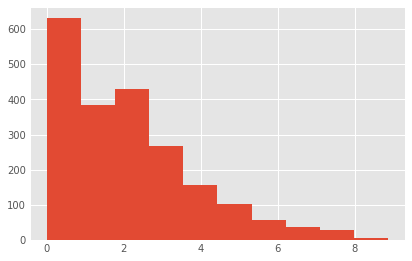

In [33]:
paraf["Positivo SARS-CoV-2"].apply(lambda x: np.log(x+1)).hist()

In [34]:
sals=(sal[sal["RESULTADO"]==3].groupby(sal[sal["RESULTADO"]==3].index)["RESULTADO"].sum())

<BarContainer object of 92 artists>

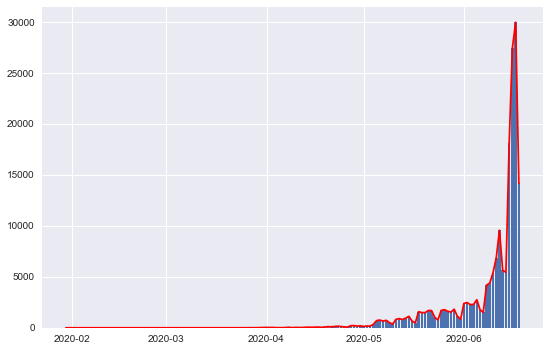

In [35]:
plt.style.use("seaborn")
#(sal[sal["RESULTADO"]==3].groupby(sal[sal["RESULTADO"]==3].index)["RESULTADO"].sum()).plot.line(linestyle="-")
plt.plot(sals.index,sals.values,color="r")
plt.bar(sals.index,sals.values)

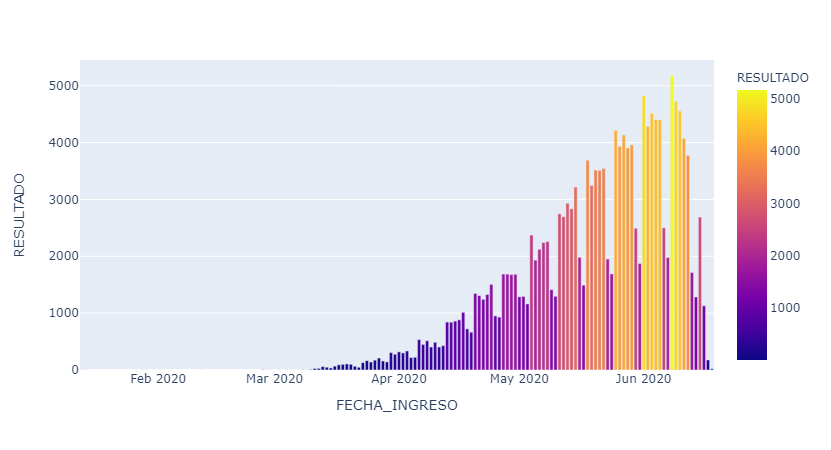

In [36]:
sals1=(sal[sal["RESULTADO"]==1].groupby(sal[sal["RESULTADO"]==1].index)["RESULTADO"].sum())
#(sal[sal["RESULTADO"]==2].groupby(sal[sal["RESULTADO"]==2].index)["RESULTADO"].sum()).plot.bar()
#plt.plot(sals1.index,sals1.rolling(5).mean().values,color="r")
#plt.bar(sals1.index,sals1.values)
fig=px.bar(sals1,y="RESULTADO",x=sals1.index,color='RESULTADO')
fig.show()
import plotly.io as pio
pio.write_html(fig, file='index.html', auto_open=True)

In [37]:
#!pip install dash
sals1.index.month.unique()

Int64Index([1, 2, 3, 4, 5, 6], dtype='int64', name='FECHA_INGRESO')

In [38]:
import dash
import dash_core_components as dcc
import dash_html_components as html

In [39]:
sc=(sal[sal["RESULTADO"]==1].groupby(sal[sal["RESULTADO"]==1].index)["RESULTADO"].sum())
#import seaborn as sns
#sns.distplot(x=sc.index,y=sc.values, kde = True)


In [40]:
sal.index.max()

Timestamp('2020-06-18 00:00:00')

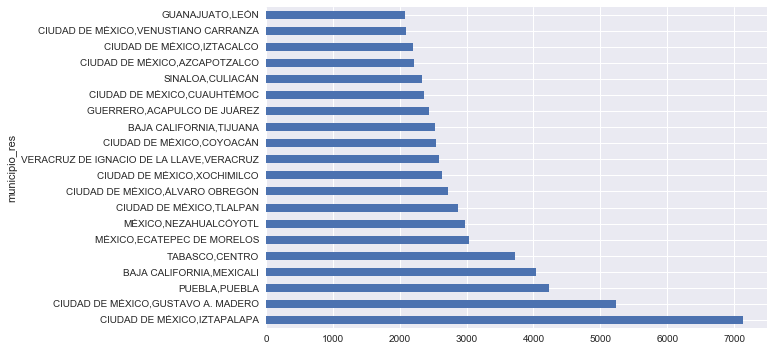

In [41]:
tops=paraf.copy()
tops.index=tops["municipio_res"]
tops.sort_values("Positivo SARS-CoV-2",ascending=False)["Positivo SARS-CoV-2"][:20].plot.barh()

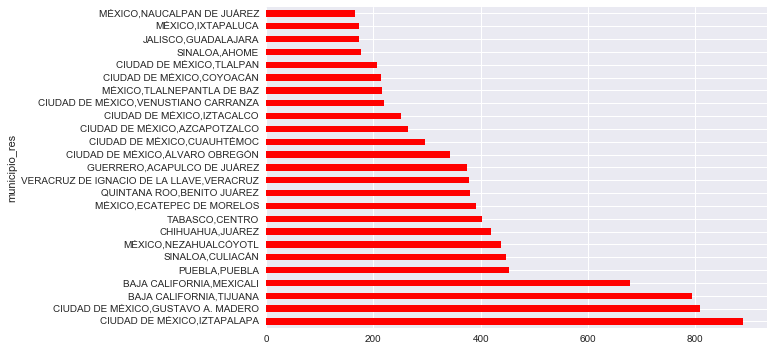

In [42]:
tops.sort_values("defunción",ascending=False)["defunción"][:25].plot.barh(color="r")

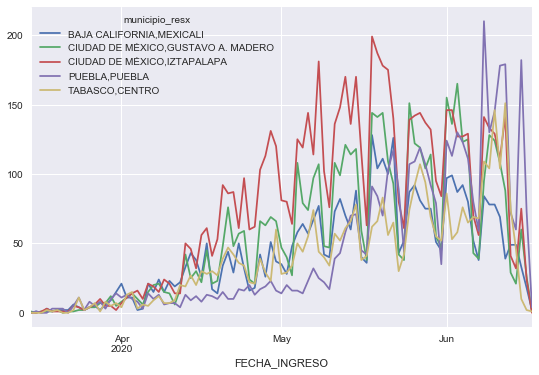

In [43]:
tps=list(tops.sort_values("Positivo SARS-CoV-2",ascending=False)["municipio_res"].values[:5])
ejxx=ejx.loc["2020-03-15":"2020-06-17"]
(((ejxx[ejxx["municipio_resx"].isin(tps)]).drop("FECHA_INGRESO",axis=1)).pivot_table(index=ejxx[ejxx["municipio_resx"].isin(tps)].index,columns="municipio_resx",values="RESULTADO"
                                                ,aggfunc=np.sum).fillna(0)).plot()

# Curvas por edo. y Mpo.

In [44]:
curvs=ejxx.copy()
curvs["edo"]=curvs["municipio_resx"].apply(lambda x: x.split(",")[0])
cr=curvs.groupby([curvs.index,"edo"]).sum()
cr=cr.reset_index()
cr.index=cr["FECHA_INGRESO"]
#cr.drop("FECHA_INGRESO",axis=1,inplace=True)
cr.head()

FECHA_INGRESO               edo  RESULTADO
FECHA_INGRESO                                           
2020-03-15       2020-03-15  CIUDAD DE MÉXICO         10
2020-03-15       2020-03-15        GUANAJUATO          2
2020-03-15       2020-03-15           HIDALGO          1
2020-03-15       2020-03-15           JALISCO          2
2020-03-15       2020-03-15            MÉXICO         10

In [45]:
#aux1=(((cr[cr["edo"]=="COLIMA"]).drop("FECHA_INGRESO",axis=1)).pivot_table(index=cr[cr["edo"]=="COLIMA"].index,columns="edo",values="RESULTADO"
#                                                ,aggfunc=np.sum).fillna(0))
#aux1.head()
#px.bar(aux1,x=aux1.index,y="COLIMA")

In [149]:
plt.style.use("fivethirtyeight")
%matplotlib inline
def curvas(ent,edo=False):
    if edo:
        aux1=(((cr[cr["edo"]==ent]).drop("FECHA_INGRESO",axis=1)).pivot_table(index=cr[cr["edo"]==ent].index,columns="edo",values="RESULTADO"
                                                ,aggfunc=np.sum).fillna(0))#.plot.bar()
        fig=px.bar(aux1,x=aux1.index,y=ent,color=ent)
        fig.show()
        #import plotly.io as pio
        #pio.write_html(fig, file='index.html', auto_open=True)
    else:
        (((ejxx[ejxx["municipio_resx"]==ent]).drop("FECHA_INGRESO",axis=1)).pivot_table(index=ejxx[ejxx["municipio_resx"]==ent].index,columns="municipio_resx",values="RESULTADO"
                                                ,aggfunc=np.sum).fillna(0)).plot.bar()

def plotcurv(byedo=True):
    if byedo:
        interact(curvas,ent=np.sort(cr["edo"].unique()))
    else:    
        interact(curvas,ent=np.sort(ejxx["municipio_resx"].unique()))
 

interact(plotcurv,byedo=[True,False])

interactive(children=(Dropdown(description='byedo', options=(True, False), value=True), Output()), _dom_classe…

<function __main__.plotcurv(byedo=True)>

In [150]:
ejxx=ejx.loc["2020-03-15":"2020-12-31"]
ej_f=(((ejxx[ejxx["municipio_resx"].isin(tps)]).drop("FECHA_INGRESO",axis=1)).pivot_table(index=ejxx[ejxx["municipio_resx"].isin(tps)].index,columns="municipio_resx",values="RESULTADO",aggfunc=np.sum).fillna(0))
#ej_f.pct_change()

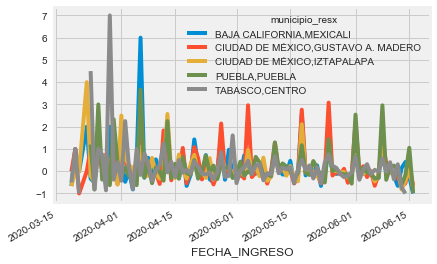

In [151]:
ej_f.pct_change().dropna().plot()

In [152]:
defu=sal[(sal["RESULTADO"]==1) & (sal["defunción"]==1)]
defu.head()

FECHA_ACTUALIZACION ID_REGISTRO  ORIGEN  ENTIDAD_UM  \
FECHA_INGRESO                                                       
2020-04-22             2020-06-17      11c08b       2          25   
2020-04-18             2020-06-17      0b3930       2          15   
2020-05-05             2020-06-17      09d970       2          15   
2020-05-03             2020-06-17      01ccf8       2          14   
2020-05-01             2020-06-17      0b99e5       2           9   

               ENTIDAD_NAC FECHA_SINTOMAS   FECHA_DEF  EDAD  NACIONALIDAD  \
FECHA_INGRESO                                                               
2020-04-22              25     2020-04-18  2020-05-04    69             1   
2020-04-18              15     2020-04-18  2020-05-08    79             1   
2020-05-05               9     2020-04-26  2020-05-06    55             1   
2020-05-03              14     2020-05-01  2020-05-17    83             1   
2020-05-01              10     2020-04-22  2020-05-07    65             1   

               RESULTADO  ...  asma inmusupr hipertension  otra_com  \
FECHA_INGRESO             ...                                         
2020-04-22             1  ...   NO       SI           NO        NO    
2020-04-18             1  ...   NO       NO           SI        NO    
2020-05-05             1  ...   NO       NO           NO        NO    
2020-05-03             1  ...   NO       NO           NO        NO    
2020-05-01             1  ...   NO       NO           NO        NO    

               cardiovascular  obesidad  renal_cronica  tabaquismo  \
FECHA_INGRESO                                                        
2020-04-22                NO        NO             NO          NO    
2020-04-18                NO        NO             NO          NO    
2020-05-05                NO        SI             NO          SI    
2020-05-03                NO        NO             NO          SI    
2020-05-01                NO        NO             NO          NO    

                     otro_caso defunción  
FECHA_INGRESO                             
2020-04-22     NO ESPECIFICADO         1  
2020-04-18     NO ESPECIFICADO         1  
2020-05-05                 SI          1  
2020-05-03     NO ESPECIFICADO         1  
2020-05-01     NO ESPECIFICADO         1  

[5 rows x 41 columns]

In [153]:
defu["FECHA_SINTOMAS"]=pd.to_datetime(defu["FECHA_SINTOMAS"])
defu["FECHA_DEF"]=pd.to_datetime(defu["FECHA_DEF"])
defu["duracion"]=((defu["FECHA_DEF"]-defu["FECHA_SINTOMAS"])/ np.timedelta64(1, 'D')).astype(int)
defu.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19080 entries, 2020-04-22 to 2020-05-28
Data columns (total 42 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   FECHA_ACTUALIZACION  19080 non-null  object        
 1   ID_REGISTRO          19080 non-null  object        
 2   ORIGEN               19080 non-null  int64         
 3   ENTIDAD_UM           19080 non-null  int64         
 4   ENTIDAD_NAC          19080 non-null  int64         
 5   FECHA_SINTOMAS       19080 non-null  datetime64[ns]
 6   FECHA_DEF            19080 non-null  datetime64[ns]
 7   EDAD                 19080 non-null  int64         
 8   NACIONALIDAD         19080 non-null  int64         
 9   RESULTADO            19080 non-null  int64         
 10  MIGRANTE             19080 non-null  int64         
 11  PAIS_NACIONALIDAD    19080 non-null  object        
 12  PAIS_ORIGEN          19080 non-null  object        
 13  UCI           

C:\Users\mb45296\AppData\Local\Continuum\anaconda4\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\mb45296\AppData\Local\Continuum\anaconda4\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\mb45296\AppData\Local\Continuum\anaconda4\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

In [154]:
defu['ent']=defu["entidad_res"]+":"+defu["municipio_res"]
defu.head()

C:\Users\mb45296\AppData\Local\Continuum\anaconda4\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



FECHA_ACTUALIZACION ID_REGISTRO  ORIGEN  ENTIDAD_UM  \
FECHA_INGRESO                                                       
2020-04-22             2020-06-17      11c08b       2          25   
2020-04-18             2020-06-17      0b3930       2          15   
2020-05-05             2020-06-17      09d970       2          15   
2020-05-03             2020-06-17      01ccf8       2          14   
2020-05-01             2020-06-17      0b99e5       2           9   

               ENTIDAD_NAC FECHA_SINTOMAS  FECHA_DEF  EDAD  NACIONALIDAD  \
FECHA_INGRESO                                                              
2020-04-22              25     2020-04-18 2020-05-04    69             1   
2020-04-18              15     2020-04-18 2020-05-08    79             1   
2020-05-05               9     2020-04-26 2020-05-06    55             1   
2020-05-03              14     2020-05-01 2020-05-17    83             1   
2020-05-01              10     2020-04-22 2020-05-07    65             1   

               RESULTADO  ...  hipertension otra_com cardiovascular  obesidad  \
FECHA_INGRESO             ...                                                   
2020-04-22             1  ...           NO       NO             NO        NO    
2020-04-18             1  ...           SI       NO             NO        NO    
2020-05-05             1  ...           NO       NO             NO        SI    
2020-05-03             1  ...           NO       NO             NO        NO    
2020-05-01             1  ...           NO       NO             NO        NO    

               renal_cronica  tabaquismo        otro_caso  defunción duracion  \
FECHA_INGRESO                                                                   
2020-04-22               NO          NO   NO ESPECIFICADO          1       16   
2020-04-18               NO          NO   NO ESPECIFICADO          1       20   
2020-05-05               NO          SI               SI           1       10   
2020-05-03               NO          SI   NO ESPECIFICADO          1       16   
2020-05-01               NO          NO   NO ESPECIFICADO          1       15   

                                          ent  
FECHA_INGRESO                                  
2020-04-22                   SINALOA:CULIACÁN  
2020-04-18                     MÉXICO:TEXCOCO  
2020-05-05     MÉXICO:COACALCO DE BERRIOZÁBAL  
2020-05-03                JALISCO:GUADALAJARA  
2020-05-01              MÉXICO:NEZAHUALCÓYOTL  

[5 rows x 43 columns]

In [155]:
def draplot(mun):
    defu[defu["ent"]==mun]["duracion"].hist()
mn=defu["ent"].unique()
interact(draplot,mun=mn)

interactive(children=(Dropdown(description='mun', options=('SINALOA:CULIACÁN', 'MÉXICO:TEXCOCO', 'MÉXICO:COACA…

<function __main__.draplot(mun)>

In [156]:
defu["duracion"].describe()

count    19080.000000
mean        11.288260
std          7.247905
min         -2.000000
25%          6.000000
50%         10.000000
75%         15.000000
max         93.000000
Name: duracion, dtype: float64

In [157]:
defu[defu["duracion"]<0]

FECHA_ACTUALIZACION ID_REGISTRO  ORIGEN  ENTIDAD_UM  \
FECHA_INGRESO                                                       
2020-05-31             2020-06-17      0606a0       1           9   

               ENTIDAD_NAC FECHA_SINTOMAS  FECHA_DEF  EDAD  NACIONALIDAD  \
FECHA_INGRESO                                                              
2020-05-31               9     2020-05-14 2020-05-12    68             1   

               RESULTADO  ...  hipertension otra_com cardiovascular  obesidad  \
FECHA_INGRESO             ...                                                   
2020-05-31             1  ...           SI       NO             NO        NO    

               renal_cronica  tabaquismo        otro_caso  defunción duracion  \
FECHA_INGRESO                                                                   
2020-05-31               NO          NO   NO ESPECIFICADO          1       -2   

                                              ent  
FECHA_INGRESO                                      
2020-05-31     CIUDAD DE MÉXICO:GUSTAVO A. MADERO  

[1 rows x 43 columns]

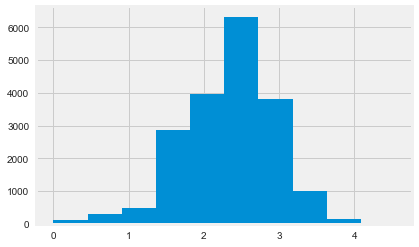

In [158]:
defu["duracion"].apply(lambda x: np.log(x+1) if x>=0 else 0).hist()

In [159]:
ejxx.head()

FECHA_INGRESO  RESULTADO                          municipio_resx
FECHA_INGRESO                                                                 
2020-03-15       2020-03-15          1          CIUDAD DE MÉXICO,BENITO JUÁREZ
2020-03-15       2020-03-15          2  CIUDAD DE MÉXICO,CUAJIMALPA DE MORELOS
2020-03-15       2020-03-15          1      CIUDAD DE MÉXICO,GUSTAVO A. MADERO
2020-03-15       2020-03-15          5         CIUDAD DE MÉXICO,MIGUEL HIDALGO
2020-03-15       2020-03-15          1                CIUDAD DE MÉXICO,TLALPAN

In [160]:
from dash.dependencies import Input, Output
import plotly.graph_objs as go 
#cr.index.max()

In [161]:
cr.drop("FECHA_INGRESO",axis=1).to_csv("cr.csv")
ejxx.drop("FECHA_INGRESO",axis=1).to_csv("ejxx.csv")
cr=pd.read_csv("cr.csv",parse_dates=True,index_col="FECHA_INGRESO")
ejxx=pd.read_csv("ejxx.csv",parse_dates=True,index_col="FECHA_INGRESO")

In [90]:
mgr_options = list(np.sort(cr["edo"].unique()))

In [91]:
mgr_options=["Pais"]+mgr_options

In [92]:
muns=["Nada"]+list(np.sort(ejxx["municipio_resx"].unique()))

In [103]:
app = dash.Dash()

app.layout = html.Div([
    
    html.Div([
    html.H1("Mapa"),
    html.Iframe(id="map",srcDoc=open("covid_por_mpio.html",encoding="utf8").read(),width="80%",height="600")
        
    ]),
        
    html.Div(
        [
            html.H2("Casos"),
            dcc.Dropdown(
                id="Manager",
                options=[{
                    'label': i,
                    'value': i
                } for i in mgr_options],
                value='Pais'),
        ],
        style={'width': '25%',
               'display': 'inline-block'}),
    
        html.Div(
        [
            html.H3("Casos Mpo."),
            dcc.Dropdown(
                id="Muns",
                options=[{
                    'label': i,
                    'value': i
                } for i in muns],
                value='Nada'),
        ],
        style={'width': '25%',
               'display': 'inline-block'}), 
    
    dcc.Graph(id='funnel-graph')   
])

@app.callback(Output('funnel-graph', 'figure'),[Input('Manager', 'value'),Input('Muns', 'value')])
def update_graph(Manager,Muns):
    if Muns=="Nada":
        

        if Manager == "Pais":

            df_plot = cr.copy()
            ax3=df_plot.groupby(df_plot.index)[["RESULTADO"]].sum()
            tr=go.Bar(x=ax3.index, y=ax3["RESULTADO"],marker=dict(color=ax3["RESULTADO"]))
        else:
            df_plot = cr[cr['edo'] == Manager]

            pv = pd.pivot_table(
                df_plot,
                index=df_plot.index,
                columns=["edo"],
                values=['RESULTADO'],
                #aggfunc=sum,
                fill_value=0)
        #    import plotly.graph_objs as go  
            tr=go.Bar(x=pv.index, y=pv[pv.columns[0]], name=Manager,marker=dict(color=pv[pv.columns[0]]))
    else:
        df_plot = ejxx[ejxx["municipio_resx"] == Muns]

        pv = pd.pivot_table(
                df_plot,
                index=df_plot.index,
                columns=["municipio_resx"],
                values=['RESULTADO'],
                #aggfunc=sum,
                fill_value=0)
        #    import plotly.graph_objs as go  
        tr=go.Bar(x=pv.index, y=pv[pv.columns[0]], name=Muns,marker=dict(color=pv[pv.columns[0]]))
        #Manager=Muns    
    return {
    'data': [tr],
    'layout':
    go.Layout(
        title='Curvas: {}'.format(Manager))}

if __name__ == '__main__':
    app.run_server(debug=True,use_reloader=False)



 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
127.0.0.1 - - [17/Jun/2020 16:10:08] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [17/Jun/2020 16:10:09] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [17/Jun/2020 16:10:09] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [17/Jun/2020 16:10:09] "GET /favicon.ico HTTP/1.1" 200 -
127.0.0.1 - - [17/Jun/2020 16:10:09] "POST /_dash-update-component HTTP/1.1" 200 -


In [193]:
ax3=cr.groupby(cr.index)[["RESULTADO"]].sum()

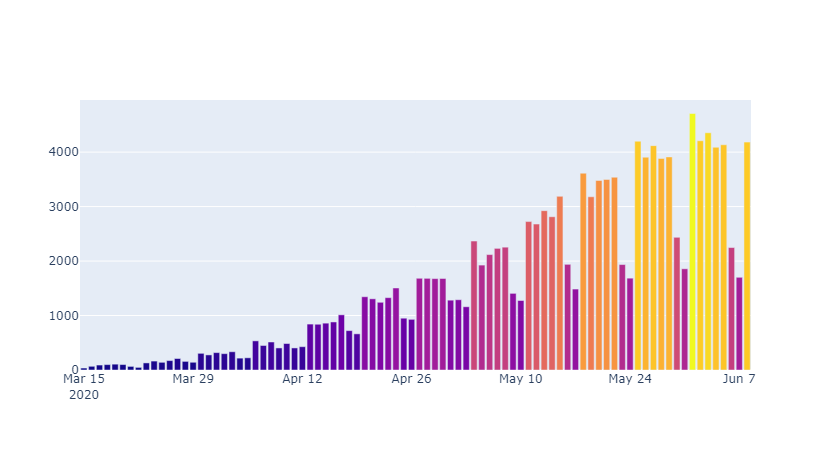

In [195]:
fig=go.Figure(data=go.Bar(x=ax3.index, y=ax3["RESULTADO"],marker=dict(color=ax3["RESULTADO"])))
fig.show()

In [213]:
pv = pd.pivot_table(
        cr[cr["edo"]=="COLIMA"],
        index=cr[cr["edo"]=="COLIMA"].index,
        columns=["edo"],
        values=['RESULTADO'],
        aggfunc=np.sum,
        fill_value=0)

In [214]:
pv.head()

RESULTADO
edo              COLIMA
FECHA_INGRESO          
2020-03-16            1
2020-03-24            1
2020-03-30            1
2020-03-31            1
2020-04-01            2

In [216]:
pd.pivot_table(
        ejxx[ejxx["municipio_resx"]=="CHIAPAS,ARRIAGA"],
        index=ejxx[ejxx["municipio_resx"]=="CHIAPAS,ARRIAGA"].index,
        columns=["municipio_resx"],
        values=['RESULTADO'],
        #aggfunc=np.sum,
        fill_value=0)

RESULTADO
municipio_resx CHIAPAS,ARRIAGA
FECHA_INGRESO                 
2020-04-14                   1
2020-04-27                   1
2020-04-30                   1
2020-05-08                   1
2020-05-12                   1
2020-05-15                   2
2020-05-16                   1
2020-05-19                   2
2020-05-20                   3
2020-05-21                   2
2020-05-23                   1
2020-05-26                   2
2020-05-28                   7
2020-05-29                   4
2020-05-31                   3
2020-06-04                   3
2020-06-05                   1
2020-06-07                   1
2020-06-08                   2

In [205]:
#fig=go.Figure(data=go.Bar(x=pv.index, y=pv[("RESULTADO","COLIMA")],marker=dict(color=pv[("RESULTADO","COLIMA")]),
                          labels={'#Casos'}))
#fig.show()

IndentationError: unexpected indent (<ipython-input-205-a6417c47923b>, line 2)

In [98]:
pv.index

DatetimeIndex(['2020-03-16', '2020-03-24', '2020-03-30', '2020-03-31',
               '2020-04-01', '2020-04-11', '2020-04-12', '2020-04-15',
               '2020-04-16', '2020-04-17', '2020-04-18', '2020-04-19',
               '2020-04-20', '2020-04-21', '2020-04-22', '2020-04-23',
               '2020-04-24', '2020-04-25', '2020-04-27', '2020-04-30',
               '2020-05-01', '2020-05-03', '2020-05-04', '2020-05-05',
               '2020-05-06', '2020-05-07', '2020-05-08', '2020-05-09',
               '2020-05-10', '2020-05-11', '2020-05-12', '2020-05-13',
               '2020-05-14', '2020-05-15', '2020-05-16', '2020-05-17',
               '2020-05-18', '2020-05-19', '2020-05-20', '2020-05-21',
               '2020-05-22', '2020-05-23', '2020-05-24', '2020-05-25',
               '2020-05-26', '2020-05-27', '2020-05-28', '2020-05-29',
               '2020-05-30', '2020-05-31', '2020-06-01', '2020-06-02',
               '2020-06-03', '2020-06-04', '2020-06-05', '2020-06-06',
      

In [235]:
!pip install heroku --classic


Usage:   
  pip install [options] <requirement specifier> [package-index-options] ...
  pip install [options] -r <requirements file> [package-index-options] ...
  pip install [options] [-e] <vcs project url> ...
  pip install [options] [-e] <local project path> ...
  pip install [options] <archive url/path> ...

no such option: --classic
